In [153]:
#Observations
#With the pandemic, 
#1. Long-term unemployment (people who are out of work 27 weeks or longer as a percent of total unemployed) 
#   has increased 8-fold.
#2. The Hispanic/Latino community had the highest unemployment at the onset of the pandemic, but has seen the
#   most dramatic improvement since.
#3. The African-American group continues to be the most impacted by the pandemic.
#4. It should come as no surprise that unemployment, during periods where there is an extraneous shock to the system 
#   such as the pandemic, is reflected as an outlier.  
#   The question is whether the outlier sets the new boundaries over time.

In [154]:
#load modules
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import json 
import requests
from config import api_key


In [155]:
#BLS url
endpoint = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'

#timeseries of monthly unemployment data to query
series = ['LNS14000000','LNS14000006','LNS14000009','LNS14032183','LNS14000003','LNS13025703'] 
startyear = '2018'
endyear = '2020'


#setup json request
headers = {'Content-type': 'application/json'}
data = json.dumps(
    {"seriesid": series,
     "registrationkey": api_key,
     "startyear":startyear, 
     "endyear":endyear})

stat = requests.post(endpoint, data=data, headers=headers)
stat_data = json.loads(stat.text)
#stat = requests.post(endpoint, data=data, headers=headers)


#setup lists to hold stats
seriesid = []
year= []
period = []
periodName = []
value = []

for series in stat_data['Results']['series']:
    seriesId = series['seriesID']
    for data in series['data']:
        year.append(data['year'])
        period.append(data['period'])
        periodName.append(data['periodName'])
        value.append(data['value'])
        seriesid.append(series['seriesID'])
 

In [156]:
#create dataframe
unemployment_df = pd.DataFrame({
    "Series":seriesid,
    "Year": year,
    "Month Code": period,
    "Month": periodName,
    "Unemployment Rate": value
})

unemployment_df.head()

,Series,Year,Month Code,Month,Unemployment Rate
0,LNS14000000,2020,M10,October,6.9
1,LNS14000000,2020,M09,September,7.9
2,LNS14000000,2020,M08,August,8.4
3,LNS14000000,2020,M07,July,10.2
4,LNS14000000,2020,M06,June,11.1


In [157]:
#Add combined Mth and Year column
unemployment_df['Mth/Year'] = pd.to_datetime(unemployment_df['Month'].astype(str)+unemployment_df['Year'], format='%B%Y')

#convert Unemployment Rate to numeric to get max and min
unemployment_df['Unemployment Rate'] = pd.to_numeric(unemployment_df['Unemployment Rate'])

#sort values
unemployment_df = unemployment_df.sort_values(by=['Series','Mth/Year'], ascending=[True,True], inplace=False, ignore_index=True)

#verify sort and check min, max
unemployment_df.head(), unemployment_df['Unemployment Rate'].min(), unemployment_df['Unemployment Rate'].max()

(        Series  Year Month Code     Month  Unemployment Rate   Mth/Year
 0  LNS13025703  2018        M01   January               21.9 2018-01-01
 1  LNS13025703  2018        M02  February               21.2 2018-02-01
 2  LNS13025703  2018        M03     March               20.6 2018-03-01
 3  LNS13025703  2018        M04     April               20.4 2018-04-01
 4  LNS13025703  2018        M05       May               19.4 2018-05-01,
 2.1,
 32.5)

In [158]:
#drop Month and Year
unemployment = unemployment_df[['Series', 'Month Code', 'Unemployment Rate', 'Mth/Year']]

unemployment.head()

,Series,Month Code,Unemployment Rate,Mth/Year
0,LNS13025703,M01,21.9,2018-01-01
1,LNS13025703,M02,21.2,2018-02-01
2,LNS13025703,M03,20.6,2018-03-01
3,LNS13025703,M04,20.4,2018-04-01
4,LNS13025703,M05,19.4,2018-05-01


In [159]:
#series description
#'LNS14000000' is 'Seasonal Total Unemployment Rate'
#'LNS14000006' is 'Unemployment-AfricanAmerican'
#'LNS14000009' is 'Unemployment-Hispanic'
#'LNS14032183' is 'Unemployment-Asian'
#'LNS14000003' is 'Unemployment-White'
#'LNS13025703' is 'Long-Term Unemployment Rate'

In [160]:
#Isolating the unemployment rate
unerate = unemployment.loc[unemployment['Series'] == 'LNS14000000',:]
uneafam = unemployment.loc[unemployment['Series'] == 'LNS14000006',:]
unehisp = unemployment.loc[unemployment['Series'] == 'LNS14000009',:]
uneasian = unemployment.loc[unemployment['Series'] =='LNS14032183',:]
unewhite = unemployment.loc[unemployment['Series'] =='LNS14000003',:]
ltunemp = unemployment.loc[unemployment['Series'] == 'LNS13025703',:]


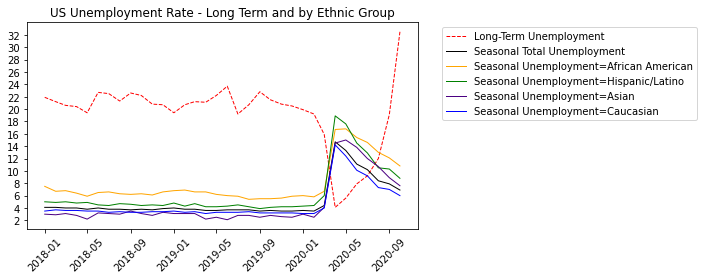

In [161]:
#line graph of x and y axis
plt.figure(figsize=(10,4))

#setting x axis 
years = ltunemp['Mth/Year']

#setting y axis 
total, = plt.plot(years, ltunemp['Unemployment Rate'], color='red', label = 'Long-Term Unemployment',linewidth =1, linestyle = '--') 
unemp, = plt.plot(years, unerate['Unemployment Rate'], color='black', label = 'Seasonal Total Unemployment',linewidth =1) 
afam, = plt.plot(years, uneafam['Unemployment Rate'], color= 'orange', label = "Seasonal Unemployment=African American", linewidth=1) 
hisp, = plt.plot(years, unehisp['Unemployment Rate'], color= 'green', label = "Seasonal Unemployment=Hispanic/Latino", linewidth=1) 
asian, = plt.plot(years, uneasian['Unemployment Rate'], color= 'indigo', label = "Seasonal Unemployment=Asian", linewidth=1) 
white, = plt.plot(years, unewhite['Unemployment Rate'], color= 'blue', label = "Seasonal Unemployment=Caucasian", linewidth=1)

#setting properties 
plt.yticks(np.arange(round(unemployment['Unemployment Rate'].min()), 
                     round(unemployment['Unemployment Rate'].max()) +1, 2.0))  
plt.xticks(rotation=45)
plt.title("US Unemployment Rate - Long Term and by Ethnic Group")  

#set legend outside of box 
plt.legend(bbox_to_anchor=(1.05, 1),handles=[total, unemp, afam, hisp, asian, white])
 
plt.tight_layout() 
plt.show()

In [162]:
# Calculate the IQR and quantitatively determine if there are any potential outliers. 
# Determine outliers using upper and lower bounds

#LT unemployment
ltrate = pd.Series(ltunemp['Unemployment Rate'])

#IQR
ltquartiles = ltrate.quantile([0.25,0.5,0.75])
ltlowerq = ltquartiles[0.25]
ltupperq = ltquartiles[0.75]
ltiqr = ltupperq - ltlowerq
ltlower_bound = ltlowerq - (1.5 * ltiqr)
ltupper_bound = ltupperq + (1.5 * ltiqr)

#outliers
ltoutliers = [rate for rate in ltrate if rate < ltlower_bound or rate > ltupper_bound]

len(ltoutliers)
ltoutliers_distinct = list(set(ltoutliers))
len(ltoutliers_distinct)
ltoutliers_distinct.sort()
ltoutliers_distinct  

ltoutliers_distinct

[4.1, 5.6, 7.9, 9.2, 12.0, 32.5]

In [163]:
# Calculate the IQR and quantitatively determine if there are any potential outliers. 
# Determine outliers using upper and lower bounds

#LT unemployment
unrate = pd.Series(unerate['Unemployment Rate'])

#IQR
unquartiles = unrate.quantile([0.25,0.5,0.75])
unlowerq = unquartiles[0.25]
unupperq = unquartiles[0.75]
uniqr = unupperq - unlowerq
unlower_bound = unlowerq - (1.5 * uniqr)
unupper_bound = unupperq + (1.5 * uniqr)

#outliers
unoutliers = [rate for rate in unrate if rate < unlower_bound or rate > unupper_bound]

len(unoutliers)
unoutliers_distinct = list(set(unoutliers))
len(unoutliers_distinct)
unoutliers_distinct.sort()
unoutliers_distinct  

unoutliers_distinct

[6.9, 7.9, 8.4, 10.2, 11.1, 13.3, 14.7]

In [164]:
# Calculate the IQR and quantitatively determine if there are any potential outliers. 
# Determine outliers using upper and lower bounds

#LT unemployment
afrate = pd.Series(uneafam['Unemployment Rate'])

#IQR
afquartiles = afrate.quantile([0.25,0.5,0.75])
aflowerq = afquartiles[0.25]
afupperq = afquartiles[0.75]
afiqr = afupperq - aflowerq
aflower_bound = aflowerq - (1.5 * afiqr)
afupper_bound = afupperq + (1.5 * afiqr)

#outliers
afoutliers = [rate for rate in afrate if rate < aflower_bound or rate > afupper_bound]

len(afoutliers)
afoutliers_distinct = list(set(afoutliers))
len(afoutliers_distinct)
afoutliers_distinct.sort()
afoutliers_distinct  

afoutliers_distinct

[10.8, 12.1, 13.0, 14.6, 15.4, 16.7, 16.8]

In [165]:
# Calculate the IQR and quantitatively determine if there are any potential outliers. 
# Determine outliers using upper and lower bounds

#LT unemployment
hprate = pd.Series(unehisp['Unemployment Rate'])

#IQR
hpquartiles = hprate.quantile([0.25,0.5,0.75])
hplowerq = hpquartiles[0.25]
hpupperq = hpquartiles[0.75]
hpiqr = hpupperq - hplowerq
hplower_bound = hplowerq - (1.5 * hpiqr)
hpupper_bound = hpupperq + (1.5 * hpiqr)

#outliers
hpoutliers = [rate for rate in hprate if rate < hplower_bound or rate > hpupper_bound]

len(hpoutliers)
hpoutliers_distinct = list(set(hpoutliers))
len(hpoutliers_distinct)
hpoutliers_distinct.sort()
hpoutliers_distinct  

hpoutliers_distinct

[8.8, 10.3, 10.5, 12.9, 14.5, 17.6, 18.9]

In [166]:
# Calculate the IQR and quantitatively determine if there are any potential outliers. 
# Determine outliers using upper and lower bounds

#LT unemployment
asrate = pd.Series(uneasian['Unemployment Rate'])

#IQR
asquartiles = asrate.quantile([0.25,0.5,0.75])
aslowerq = asquartiles[0.25]
asupperq = asquartiles[0.75]
asiqr = asupperq - aslowerq
aslower_bound = aslowerq - (1.5 * asiqr)
asupper_bound = asupperq + (1.5 * asiqr)

#outliers
asoutliers = [rate for rate in asrate if rate < aslower_bound or rate > asupper_bound]

len(asoutliers)
asoutliers_distinct = list(set(asoutliers))
len(asoutliers_distinct)
asoutliers_distinct.sort()
asoutliers_distinct  

asoutliers_distinct

[7.6, 8.9, 10.7, 12.0, 13.8, 14.5, 15.0]

In [167]:
# Calculate the IQR and quantitatively determine if there are any potential outliers. 
# Determine outliers using upper and lower bounds

#LT unemployment
wtrate = pd.Series(unewhite['Unemployment Rate'])

#IQR
wtquartiles = wtrate.quantile([0.25,0.5,0.75])
wtlowerq = wtquartiles[0.25]
wtupperq = wtquartiles[0.75]
wtiqr = wtupperq - wtlowerq
wtlower_bound = wtlowerq - (1.5 * wtiqr)
wtupper_bound = wtupperq + (1.5 * wtiqr)

#outliers
wtoutliers = [rate for rate in wtrate if rate < wtlower_bound or rate > wtupper_bound]

len(wtoutliers)
wtoutliers_distinct = list(set(wtoutliers))
len(wtoutliers_distinct)
wtoutliers_distinct.sort()
wtoutliers_distinct  

wtoutliers_distinct

[6.0, 7.0, 7.3, 9.2, 10.1, 12.4, 14.2]

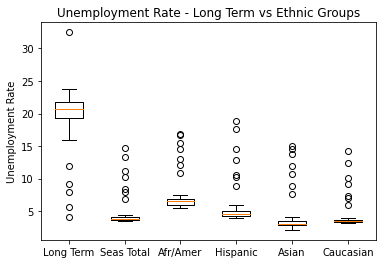

In [168]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest
fig1, ax1 = plt.subplots()
ax1.set_title('Unemployment Rate - Long Term vs Ethnic Groups')
ax1.set_ylabel('Unemployment Rate')
ax1.boxplot([ltrate,unrate, afrate, hprate, asrate, wtrate], showfliers=True)
plt.xticks([1,2,3,4,5,6],['Long Term', 'Seas Total',"Afr/Amer", 'Hispanic','Asian','Caucasian'])
plt.show()

In [221]:
#retrieve US Covid cases file
#load file
#file source: https://ourworldindata.org/coronavirus/country/united-states?country=~USA
covid_path = "D:\\GroupProject1\\Statistics\\owid-covid-data.csv"

#Read the data and remove commas from numbers
covid = pd.read_csv(covid_path,  encoding = 'iso-8859-1', low_memory=False)

covid = covid.loc[(covid['location'] == 'United States')]
covid.tail()


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
52880,USA,North America,United States,11/9/2020,9971651.0,110693.0,109184.143,237572.0,459.0,939.429,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
52881,USA,North America,United States,11/10/2020,10110552.0,138901.0,117043.857,238251.0,679.0,957.143,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
52882,USA,North America,United States,11/11/2020,10257826.0,147274.0,124835.286,239683.0,1432.0,1008.000,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
52883,USA,North America,United States,11/12/2020,10401132.0,143306.0,130663.714,241800.0,2117.0,1153.000,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
52884,USA,North America,United States,11/13/2020,10554801.0,153669.0,135125.571,242430.0,630.0,1070.429,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924


In [222]:
#convert dates to datetime
covid['date'] = pd.to_datetime(covid['date'].astype(str),format='%m/%d/%Y')
covid['Year'] = covid['date'].dt.year
covid['Month'] = covid['date'].dt.month

#set up new Mth/Yr column to simplify dates with day = 01 for grouping and plotting
covid['Mth/Year'] = pd.to_datetime(covid['Month'].astype(str)+covid['Year'].astype(str), format='%m%Y')
covid_df = covid[['location','date','new_cases', 'Mth/Year']]

#sort data and reset index
covid_df = covid_df.sort_values(by='Mth/Year')
covid_df = covid_df.reset_index(drop=True)
covid_df.head()

,location,date,new_cases,Mth/Year
0,United States,2019-12-31,0.0,2019-12-01
1,United States,2020-01-31,1.0,2020-01-01
2,United States,2020-01-30,0.0,2020-01-01
3,United States,2020-01-29,0.0,2020-01-01
4,United States,2020-01-28,0.0,2020-01-01


In [312]:
#group to sum new cases into month groups
covid_grp = covid_df.groupby(['Mth/Year'])
newcases = covid_grp['new_cases'].sum()

#convert to DF and clean up to list 2020 only
newcases = pd.DataFrame(newcases)
newcases = newcases.reset_index()
newcases = newcases.drop(newcases.index[[0,11]])
newcases

,Mth/Year,new_cases
1,2020-01-01,6.0
2,2020-02-01,60.0
3,2020-03-01,164554.0
4,2020-04-01,875289.0
5,2020-05-01,730475.0
6,2020-06-01,820168.0
7,2020-07-01,1904462.0
8,2020-08-01,1502149.0
9,2020-09-01,1193898.0
10,2020-10-01,1856366.0


In [313]:
#select LT Unemployment for 2020
ltunemp2020 = unemployment_df[['Series', 'Year', 'Unemployment Rate', 'Mth/Year']]
ltunemp2020 = ltunemp2020.loc[(ltunemp2020['Year'] == '2020') & (ltunemp2020['Series'] == 'LNS13025703')]
ltunemp2020 = ltunemp2020.reset_index(drop=True)
ltunemp2020['Mth/Year'] = pd.to_datetime(ltunemp2020['Mth/Year'])
ltunemp2020
#include = df[df['Date'].dt.year == year]

,Series,Year,Unemployment Rate,Mth/Year
0,LNS13025703,2020,19.9,2020-01-01
1,LNS13025703,2020,19.2,2020-02-01
2,LNS13025703,2020,15.9,2020-03-01
3,LNS13025703,2020,4.1,2020-04-01
4,LNS13025703,2020,5.6,2020-05-01
5,LNS13025703,2020,7.9,2020-06-01
6,LNS13025703,2020,9.2,2020-07-01
7,LNS13025703,2020,12.0,2020-08-01
8,LNS13025703,2020,19.1,2020-09-01
9,LNS13025703,2020,32.5,2020-10-01


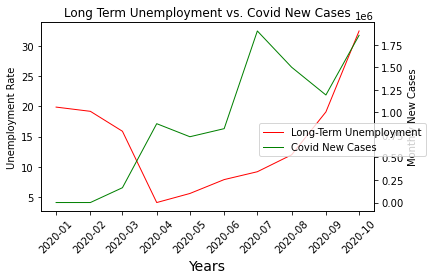

In [314]:
#Plot LongTerm Unemployment with Covid Cases

fig = plt.figure()
ax = fig.add_subplot(111)

#fig, ax = plt.subplots(constrained_layout=True)

#setting x axis 
years = ltunemp2020['Mth/Year']

#make a plot
ax.plot(years, ltunemp2020['Unemployment Rate'], color='red', label = 'Long-Term Unemployment',linewidth =1) 
ax.set_xlabel('Years', fontsize=14)
ax.set_ylabel('Unemployment Rate')
plt.xticks(rotation=45)

#setting 2nd y axis
ax2= ax.twinx()
ax2.plot(years, newcases['new_cases'], color='green', label = 'Covid New Cases',linewidth =1)  
ax2.set_ylabel('Monthly New Cases')

plt.title("Long Term Unemployment vs. Covid New Cases") 
#set legend outside of box 
fig.legend(loc='right')

#setting properties 
plt.tight_layout() 
plt.show()



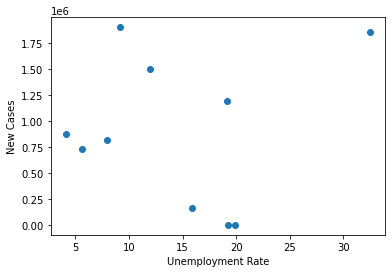

In [316]:
# Generate a scatter plot of unemployment vs. covid new cases for the Capomulin regimen
unemp = ltunemp2020['Unemployment Rate']
new = newcases['new_cases']

plt.scatter(unemp, new)
plt.ylabel('New Cases')
plt.xlabel('Unemployment Rate')
plt.show()


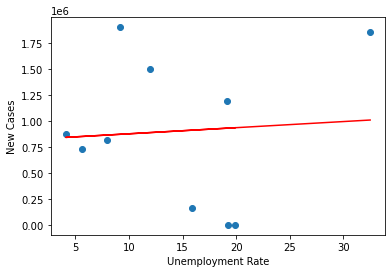

In [324]:
correlation = st.pearsonr(unemp, new)
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(unemp, new)
regress_values = unemp * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(unemp, new)
plt.plot(unemp,regress_values,"r-")
plt.annotate(line_eq,(1.00,36),fontsize=15,color="red")
plt.ylabel('New Cases')
plt.xlabel('Unemployment Rate')
plt.show()
